# Partitional Clustering of Countries Economic Development

## Introduction

The aim of this notebook is to determine which time series specific clustering algorithm is optimal for grouping the financial growth of 113 countries over the past 58 years. 

### Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from tslearn.clustering import silhouette_score

from Clustering import TimeSeriesPartitions

from Utils import DataUtils, PreProcessing, VisualUtils, TimeSeriesUtils

## Data

For each country, the time series of the annual evolution of its GDP per capite is considered. Data for all countries is continuously available from 1960 to 2017. Because these time series display very high variance, the logarithm of the series is taken to smoothen the results.

The data is loaded from a `.csv` file to create a $113 \times 58$ matrix. The data is then standardized and passed into a `pandas.DataFrame` object.

In [2]:
n = 113
T_gdp = 118
T_pop = 118
T = 58
start_year = 1960

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
population_path = "Data/pop_raw.csv"
currency_path = "Data/currency.csv"
map_path = "Data/Map/ne_110m_admin_0_countries.shp"

In [3]:
names, gdp, pop, currency, map = DataUtils.load_clustering_data(
    names_path, gdp_path, population_path, currency_path, map_path, n, T_gdp, T_pop, T
)
gdp_data = np.log(gdp[:, -T:])
pop_data = pop[:, -T:]

In [4]:
df, scaled_df, scaled_data = PreProcessing.preprocess_onlyGDP(names, gdp_data, start_year, T)

## Time Series Partitioning Algorithms

This section gives a short description of the partitioning algorithms used in the notebook.

### $k$-Means with Euclidean Distance Measure

This algorithm is the standard $k$-Means algorithm using the euclidean distance measure.

### $k$-Means with Dynamic Time Warping (DTW)

This version of the $k$-Means algorithm has two distinct differences from the standard $k$-Means:
- First, dynamic time warping (DTW) is used instead of euclidean distance as the distance measure. DTW is an alignment-based technique used to measure similarity between two time series. It aligns sequences non-linearly by stretching or compressing sections of the data to find the optimal match between corresponding points. 
- Second, the cluster centers (centroids) are calculated using the DTW Barycenter Averaging (DBA) algorithm. DBA computes the centroids as an average time series of the time series in the respective clusters by minimizing the total DTW distance between the average and the time series.

### $k$-Shapes

The $k$-Shapes algorithm is specifically designed for time series data, focusing on shape-based similarity. It uses a normalized version of cross-correlation to compare the shapes of the time series. The algorithm iteratively assigns time series to clusters by finding the shape-based centroids, which are computed preserving the temporal alignment of the data.

### $k$-Medoids with DTW

$k$-Medoids operates in the same way as the $k$-Means algorithm, except for the centroid calculation. This algorithm only considers elements of the dataset as potential centroids; that is, for each cluster, the algorithm selects the centroid as the time series in that cluster that minimizes the withing group sum of squared errors. $k$-Medoids is robust to outliers, in the sense that the cluster centers are not affected by outliers at all.

### Kernel $k$-Means

Kernel $k$-Means extends the traditional $k$-Means algorithm by operating in a higher dimensional feature space, using a kernel function. This allows the algorithm to capture non-linear trends between the data points. The algorithm applies the kernel to map the data into a higher-dimensional space, where cluster assignment and centroid updates are achieved similarly to $k$-Means. The main downside of this algorithm is that the cluster centroids in the original space are never explicitly calculated. In the context of clustering time series, the Global Alignment Kernel (GAK) is used a kernel function.

## Selecting the appropriate algorithm and number of clusters

In order to determine which of the above algorithms is better for this task and with which number of clusters, the elbow heuristic is used. For time efficiency, we only consider $3 \leq k \leq 10$ clusters. Indeed, it is clear for the following elbow plot that the increase of the number of clusters to values larger than 10 are hihgly unlikely to produce improvements to the performance of the algorithms. Since this is a task of unsupervised clustering, the silhouette score measure is used to evaluate algorithm performance. 

As all algorithms are sensitive to initialization, each algorithm is initialized 25 times and the best performance of the 25 iterations is then kept.

In [5]:
k_arr = np.arange(3, 10)
n_init=100

$k$-Means with euclidean distance

In [6]:
scores_km_e = []
for k in k_arr:
    y, _ = TimeSeriesPartitions.kmeans_euclidean(scaled_df, k, n_init)
    scores_km_e.append(silhouette_score(scaled_df, y))

$k$-Means with DTW

In [7]:
scores_km_dba = []
for k in k_arr:
    y, _ = TimeSeriesPartitions.kmeans_dtw(scaled_df, k, n_init)
    scores_km_dba.append(silhouette_score(scaled_df, y))

$k$-Shape

In [8]:
scores_kshape = []
for k in k_arr:
    y, _ = TimeSeriesPartitions.kshape(scaled_df, k, n_init)
    scores_kshape.append(silhouette_score(scaled_df, y))

$k$-Medoids with DTW

In [9]:
scores_med_dba = []
for k in k_arr:
    y, _ = TimeSeriesPartitions.kmedoids_dtw(scaled_df, k, n_init)
    scores_med_dba.append(silhouette_score(scaled_df, y))

Kernel $k$-Means

In [10]:
scores_kernel = []
for k in k_arr:
    y = TimeSeriesPartitions.kernel_k_means(scaled_df, k, n_init)
    scores_kernel.append(silhouette_score(scaled_df, y))

### Elbow Plots

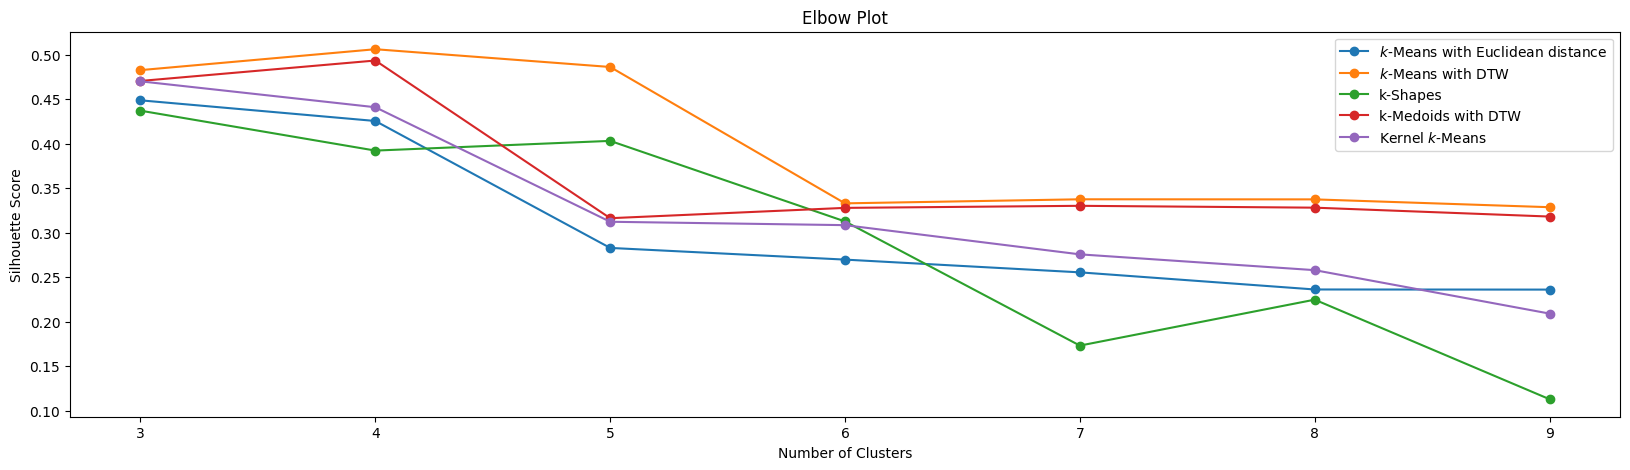

In [11]:
plt.figure(figsize=(20,5))
plt.title('Elbow Plot')
plt.plot(k_arr, scores_km_e, marker='o', linestyle='-', label='$k$-Means with Euclidean distance')
plt.plot(k_arr, scores_km_dba, marker='o', linestyle='-', label='$k$-Means with DTW')
plt.plot(k_arr, scores_kshape, marker='o', linestyle='-', label='k-Shapes')
plt.plot(k_arr, scores_med_dba, marker='o', linestyle='-', label='k-Medoids with DTW')
plt.plot(k_arr, scores_kernel, marker='o', linestyle='-', label='Kernel $k$-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

## Findings of the best algorithms

We now present the outcomes of the two algorithms that achieved the best performance in the previous section:

### $k$-means with Euclidean distance and $k=5$ clusters

Silhouette Score: 0.28145347031651424
Cluster #1 size: 10
Cluster #1 members: BOL, ETH, GHA, KHM, LBN, PER, SDN, SEN, TCD, UGA
Cluster #2 size: 46
Cluster #2 members: AUS, AUT, BEL, BEN, BGR, BRA, CAN, CHE, COG, COL, DEU, DNK, DZA, ECU, EGY, ESP, FIN, FRA, GBR, GRC, GTM, HKG, HUN, IDN, ISR, ITA, JPN, KOR, MEX, MYS, NLD, NOR, OMN, PAK, PRT, PRY, PSE, ROU, SGP, SWE, SYR, THA, TUN, TWN, USA, YEM
Cluster #3 size: 12
Cluster #3 members: CAF, CIV, COD, HTI, IRN, LBR, MDG, NER, NIC, SLE, TGO, ZMB
Cluster #4 size: 12
Cluster #4 members: BDI, CMR, HRV, IRQ, MRT, MWI, RUS, SAU, SRB, VEN, ZAF, ZWE
Cluster #5 size: 33
Cluster #5 members: ARG, BFA, BGD, BIH, CHL, CHN, CRI, DOM, GIN, HND, IND, IRL, JOR, KEN, LAO, LKA, MAR, MLI, MMR, MNG, MOZ, NGA, NPL, NZL, PAN, PHL, POL, RWA, SLV, TUR, TZA, URY, VNM


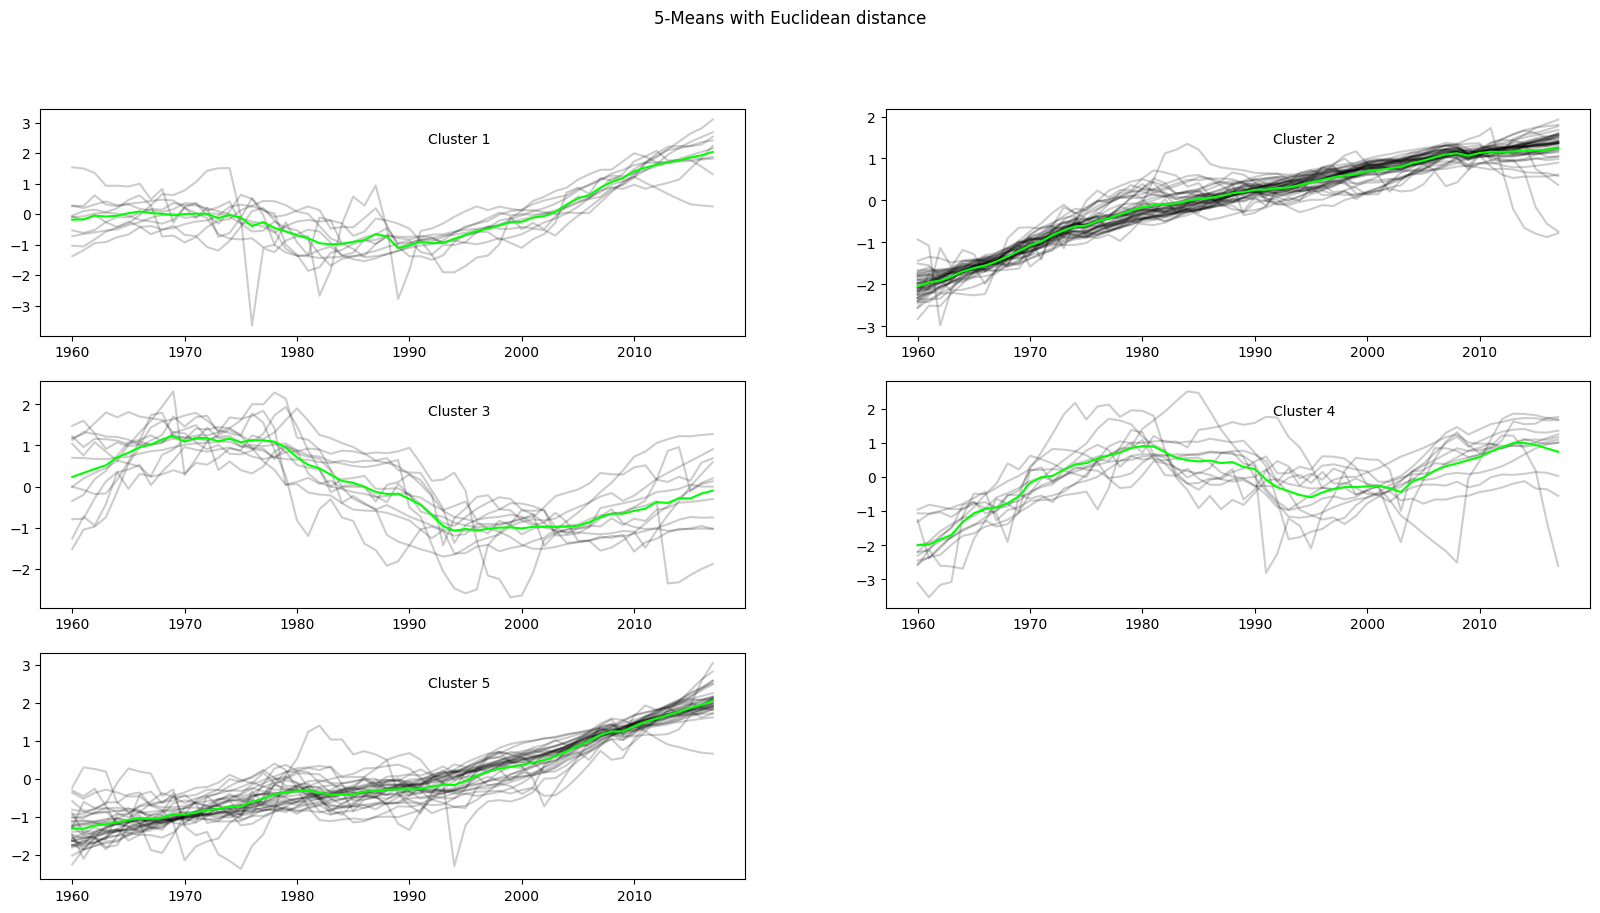

In [12]:
y_km_e, cluster_centers_km_e = TimeSeriesPartitions.kmeans_euclidean(scaled_df, 5, n_init)

score_km_e = silhouette_score(scaled_df, y_km_e)
clusters_km = VisualUtils.show_clustering(
    names, 
    5, 
    scaled_data, 
    cluster_centers_km_e, 
    y_km_e, 
    score_km_e, 
    3, 
    2, 
    start_year, 
    T, 
    "5-Means with Euclidean distance"
)

### $k$-Means with DTW and $k=6$ clusters

Silhouette Score: 0.27085696349498406
Cluster #1 size: 28
Cluster #1 members: AUT, BEL, BGR, BRA, CAN, CHE, COG, DEU, DNK, ESP, FIN, FRA, GRC, GTM, HRV, HUN, ITA, JPN, MEX, MRT, MWI, NLD, NOR, OMN, PRT, ROU, RUS, ZAF
Cluster #2 size: 6
Cluster #2 members: CAF, COD, HTI, LBR, MDG, NER
Cluster #3 size: 12
Cluster #3 members: CIV, CMR, IRN, IRQ, LBN, NIC, SEN, SLE, SRB, TGO, ZMB, ZWE
Cluster #4 size: 13
Cluster #4 members: BGD, BOL, ETH, GHA, GIN, KHM, MOZ, NGA, PER, RWA, SDN, TCD, UGA
Cluster #5 size: 48
Cluster #5 members: ARG, AUS, BEN, BFA, BIH, CHL, CHN, COL, CRI, DOM, DZA, ECU, EGY, GBR, HKG, HND, IDN, IND, IRL, ISR, KEN, KOR, LAO, LKA, MAR, MLI, MMR, MNG, MYS, NPL, NZL, PAK, PAN, PHL, POL, PRY, PSE, SGP, SLV, SWE, THA, TUN, TUR, TWN, TZA, URY, USA, VNM
Cluster #6 size: 6
Cluster #6 members: BDI, JOR, SAU, SYR, VEN, YEM


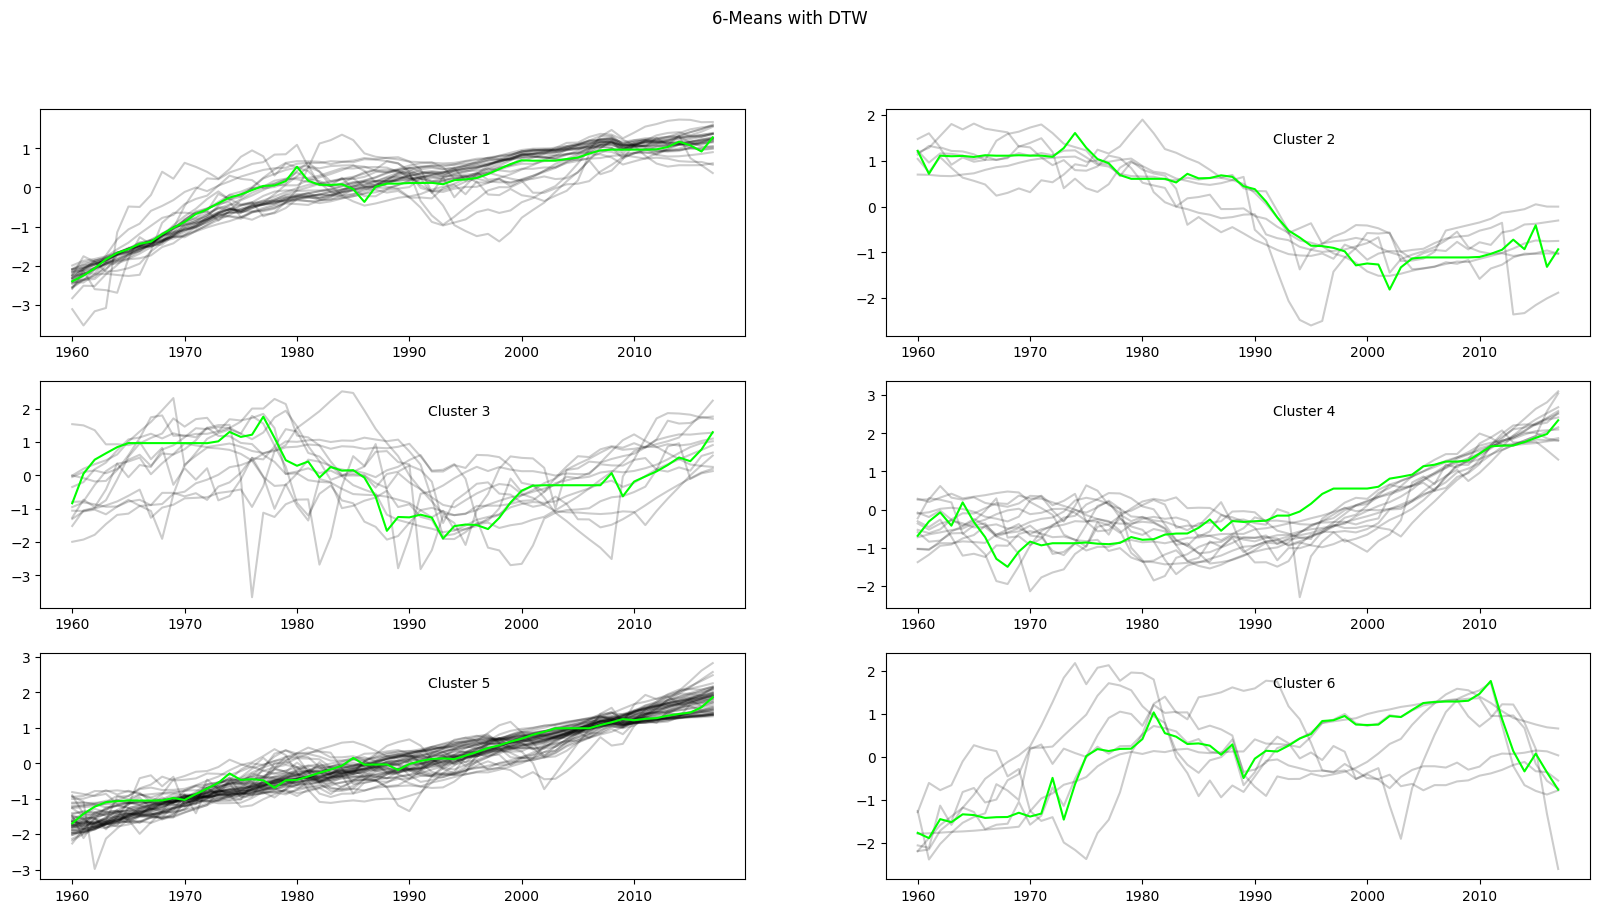

In [13]:
y_km, cluster_centers_km = TimeSeriesPartitions.kmeans_dtw(scaled_df, 6, n_init)

score_km = silhouette_score(scaled_df, y_km)
clusters_km = VisualUtils.show_clustering(
    names, 
    6, 
    scaled_data, 
    cluster_centers_km, 
    y_km, 
    score_km, 
    3, 
    2, 
    start_year, 
    T, 
    "6-Means with DTW"
)

### $k$-Shapes with $k=5$ clusters

Silhouette Score: 0.33831348642262876
Cluster #1 size: 12
Cluster #1 members: ARG, DZA, HRV, IRQ, KEN, MRT, MWI, PHL, RUS, SRB, VEN, ZAF
Cluster #2 size: 12
Cluster #2 members: CAF, CIV, COD, HTI, IRN, LBR, MDG, NER, NIC, SLE, TGO, ZMB
Cluster #3 size: 2
Cluster #3 members: JOR, ZWE
Cluster #4 size: 19
Cluster #4 members: BDI, BGD, BOL, CMR, ETH, GHA, GIN, KHM, MMR, MOZ, NGA, PER, RWA, SAU, SDN, SEN, TCD, TZA, UGA
Cluster #5 size: 68
Cluster #5 members: AUS, AUT, BEL, BEN, BFA, BGR, BIH, BRA, CAN, CHE, CHL, CHN, COG, COL, CRI, DEU, DNK, DOM, ECU, EGY, ESP, FIN, FRA, GBR, GRC, GTM, HKG, HND, HUN, IDN, IND, IRL, ISR, ITA, JPN, KOR, LAO, LBN, LKA, MAR, MEX, MLI, MNG, MYS, NLD, NOR, NPL, NZL, OMN, PAK, PAN, POL, PRT, PRY, PSE, ROU, SGP, SLV, SWE, SYR, THA, TUN, TUR, TWN, URY, USA, VNM, YEM


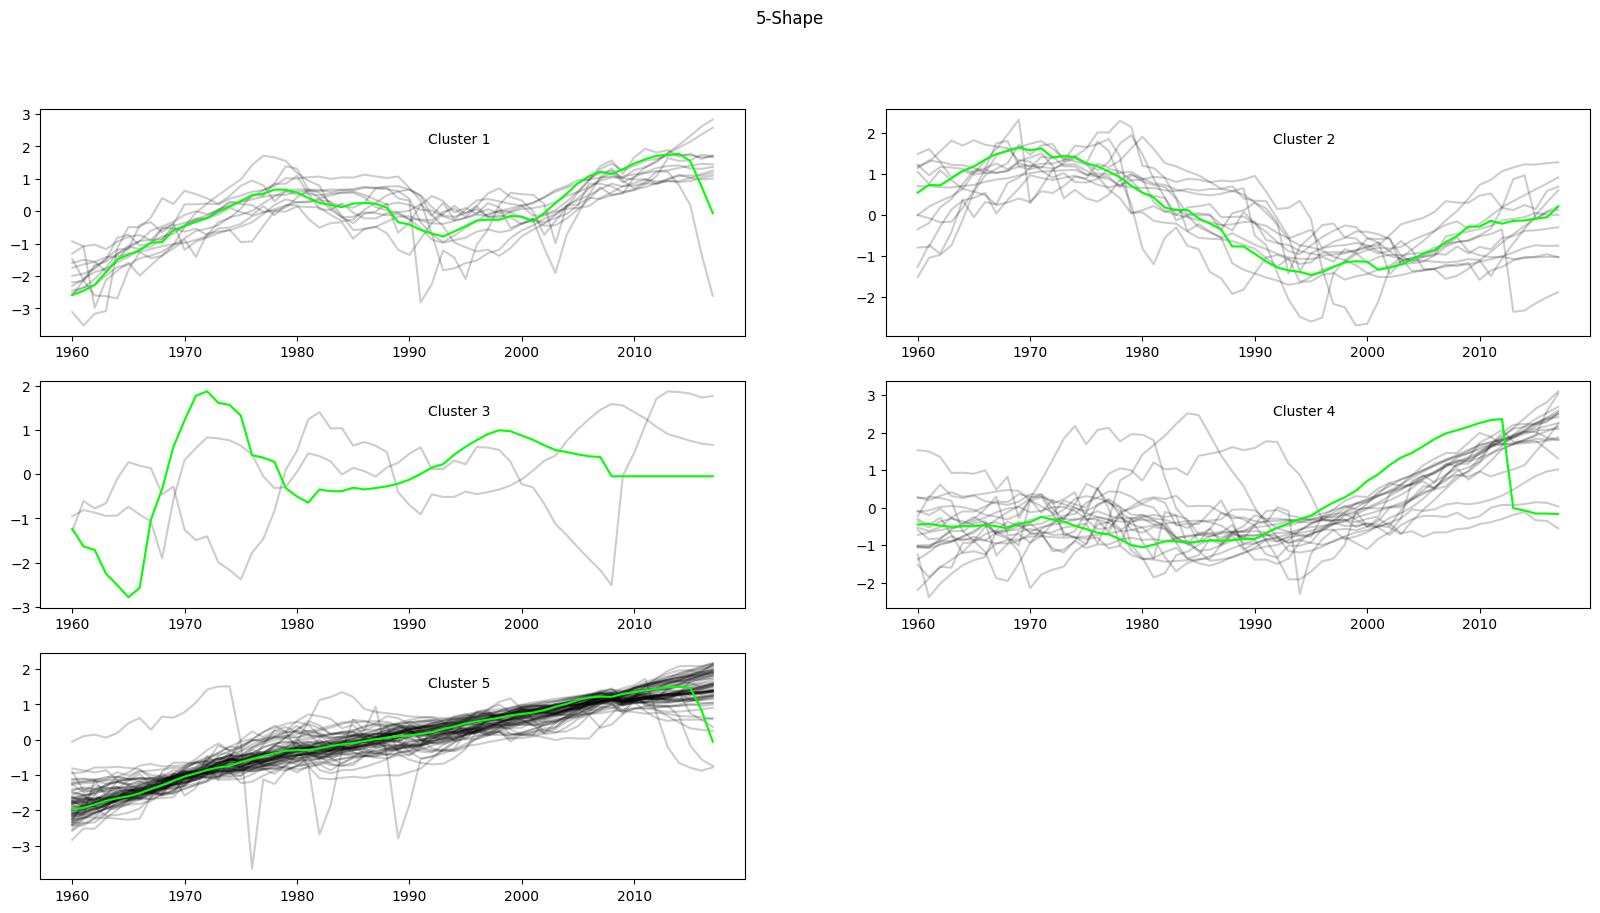

In [14]:
y_s, cluster_centers_s = TimeSeriesPartitions.kshape(scaled_df, 5, n_init)

score_s = silhouette_score(scaled_df, y_s)
clusters_kmed = VisualUtils.show_clustering(
    names, 
    5, 
    scaled_data, 
    cluster_centers_s, 
    y_s, 
    score_s, 
    3, 
    2, 
    start_year, 
    T, 
    "5-Shape"
)

### $k$-Medoids with DTW and $k=5$ clusters

Silhouette Score: 0.3163307919694361
Cluster #1 size: 42
Cluster #1 members: AUS, AUT, BEL, BGR, BRA, CAN, CHE, COG, DEU, DNK, DZA, EGY, ESP, FIN, FRA, GBR, GRC, HKG, HRV, HUN, ISR, ITA, JPN, KOR, MEX, MRT, MWI, MYS, NLD, NOR, OMN, PAK, PRT, PSE, ROU, SGP, SWE, THA, TUN, TWN, USA, YEM
Cluster #2 size: 37
Cluster #2 members: ARG, BEN, BFA, BIH, CHL, CHN, COL, CRI, DOM, ECU, GTM, HND, IDN, IND, IRL, KEN, LAO, LKA, MAR, MLI, MMR, MNG, MOZ, NGA, NPL, NZL, PAN, PHL, POL, PRY, RUS, SLV, TUR, TZA, URY, VNM, ZAF
Cluster #3 size: 14
Cluster #3 members: BDI, CIV, CMR, IRN, JOR, LBN, NIC, SAU, SLE, SRB, SYR, TGO, VEN, ZMB
Cluster #4 size: 14
Cluster #4 members: BGD, BOL, ETH, GHA, GIN, IRQ, KHM, PER, RWA, SDN, SEN, TCD, UGA, ZWE
Cluster #5 size: 6
Cluster #5 members: CAF, COD, HTI, LBR, MDG, NER


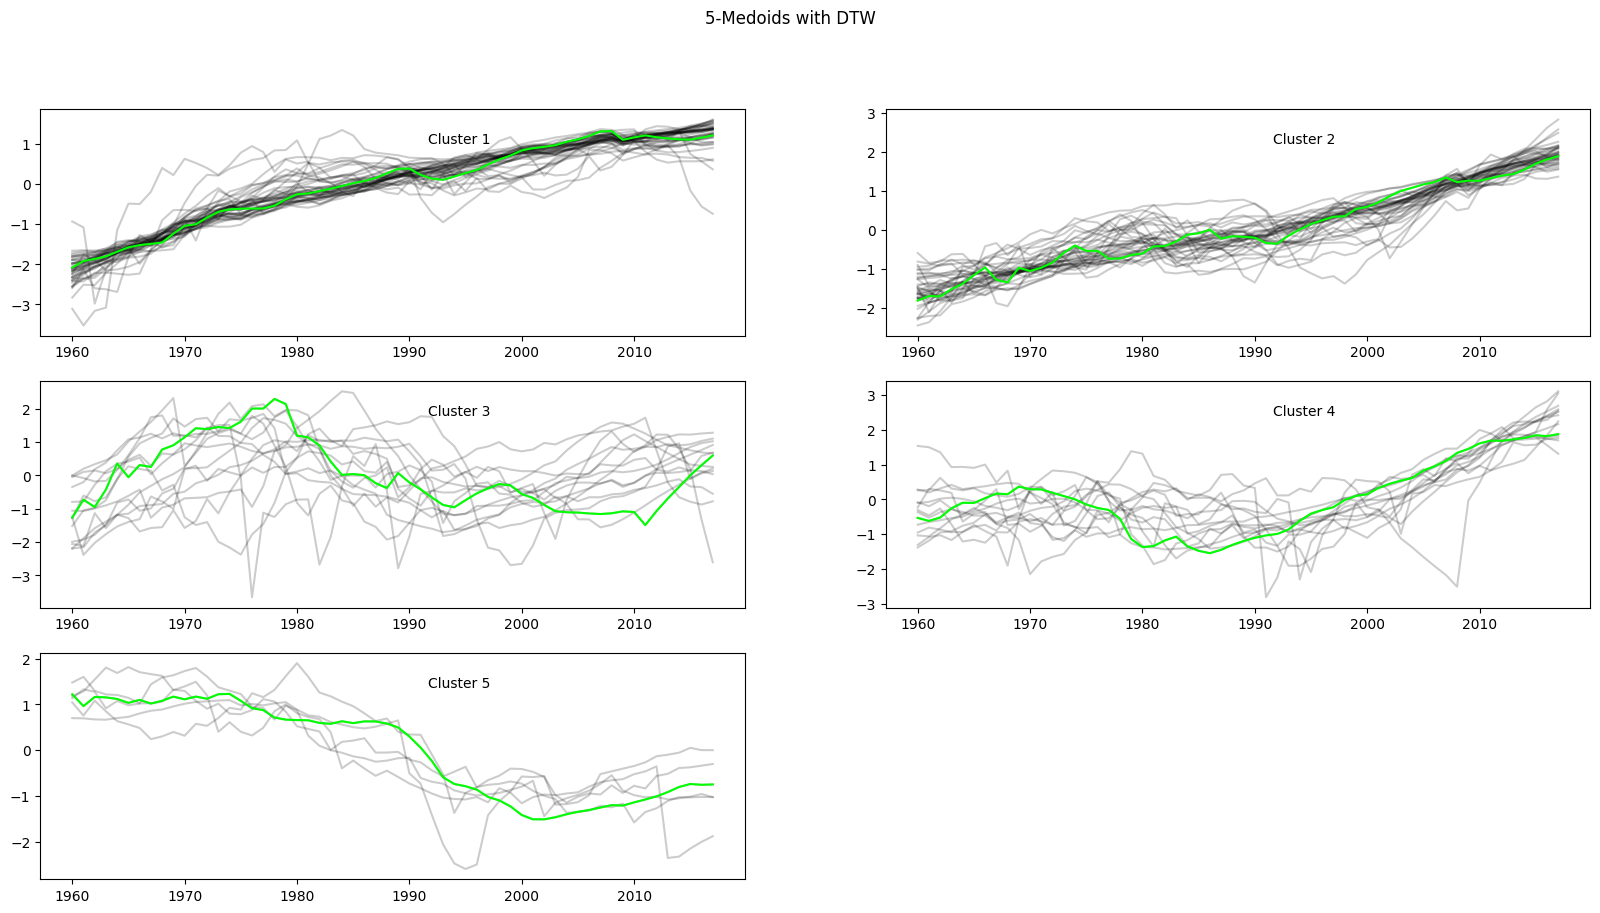

In [15]:
y_kmed, cluster_centers_kmed = TimeSeriesPartitions.kmedoids_dtw(scaled_df, 5, n_init)

score_kmed = silhouette_score(scaled_df, y_kmed)
clusters_kmed = VisualUtils.show_clustering(
    names, 
    5, 
    scaled_data, 
    cluster_centers_kmed, 
    y_kmed, 
    score_kmed, 
    3, 
    2, 
    start_year, 
    T, 
    "5-Medoids with DTW"
)

### Kernel $k$-means with GAK and $k=6$ clusters

Silhouette Score: 0.2550431921954222
Cluster #1 size: 8
Cluster #1 members: BDI, CMR, MRT, RUS, SAU, SRB, VEN, ZWE
Cluster #2 size: 29
Cluster #2 members: BEN, BFA, BGD, BIH, CHL, CHN, CRI, DOM, GIN, HND, IND, IRL, JOR, KEN, LAO, LKA, MAR, MLI, MMR, MNG, NPL, NZL, PAN, PHL, POL, SLV, TUR, URY, VNM
Cluster #3 size: 11
Cluster #3 members: ARG, BOL, ETH, IRQ, MOZ, NGA, PER, RWA, SDN, TZA, ZAF
Cluster #4 size: 6
Cluster #4 members: GHA, KHM, LBN, SEN, TCD, UGA
Cluster #5 size: 12
Cluster #5 members: CAF, CIV, COD, HTI, IRN, LBR, MDG, NER, NIC, SLE, TGO, ZMB
Cluster #6 size: 47
Cluster #6 members: AUS, AUT, BEL, BGR, BRA, CAN, CHE, COG, COL, DEU, DNK, DZA, ECU, EGY, ESP, FIN, FRA, GBR, GRC, GTM, HKG, HRV, HUN, IDN, ISR, ITA, JPN, KOR, MEX, MWI, MYS, NLD, NOR, OMN, PAK, PRT, PRY, PSE, ROU, SGP, SWE, SYR, THA, TUN, TWN, USA, YEM


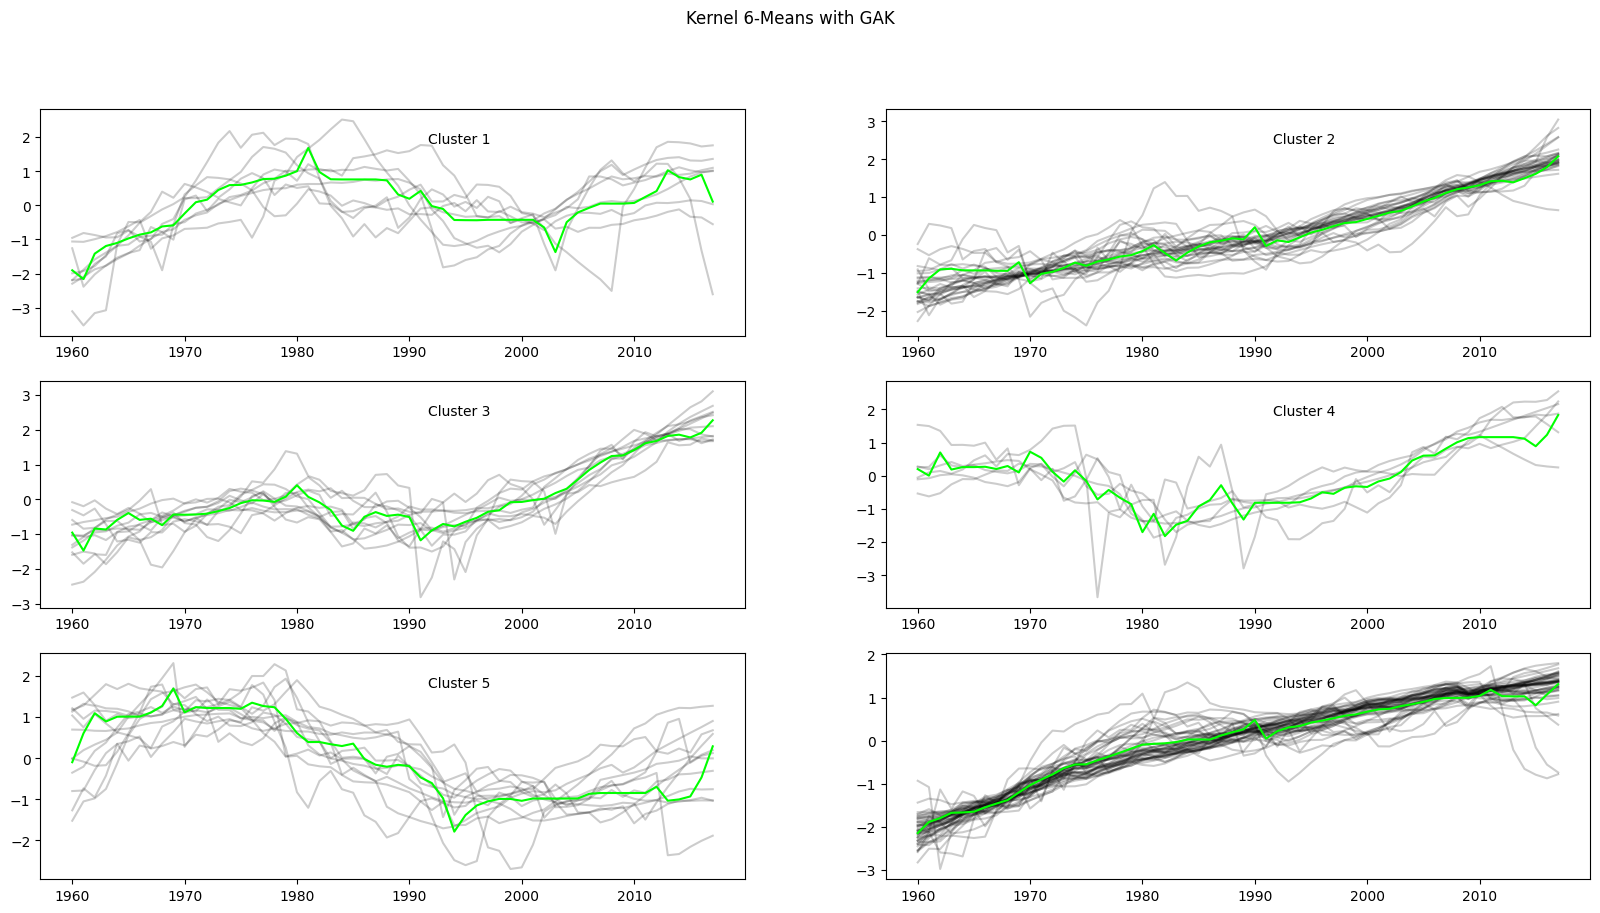

In [16]:
y_k = TimeSeriesPartitions.kernel_k_means(scaled_df, 6, n_init)
cluster_centers_k = TimeSeriesUtils.cluster_centroids(scaled_data, 6, y_k, T)
score_k = silhouette_score(scaled_df, y_k)
clusters_kmed = VisualUtils.show_clustering(
    names, 
    6, 
    scaled_data, 
    cluster_centers_k, 
    y_k, 
    score_k, 
    3, 
    2, 
    start_year, 
    T, 
    "Kernel 6-Means with GAK"
)

### Visualization on Map

In [17]:
locations_path = "Data/locations.csv"
locations = DataUtils.load_locations(n, locations_path)

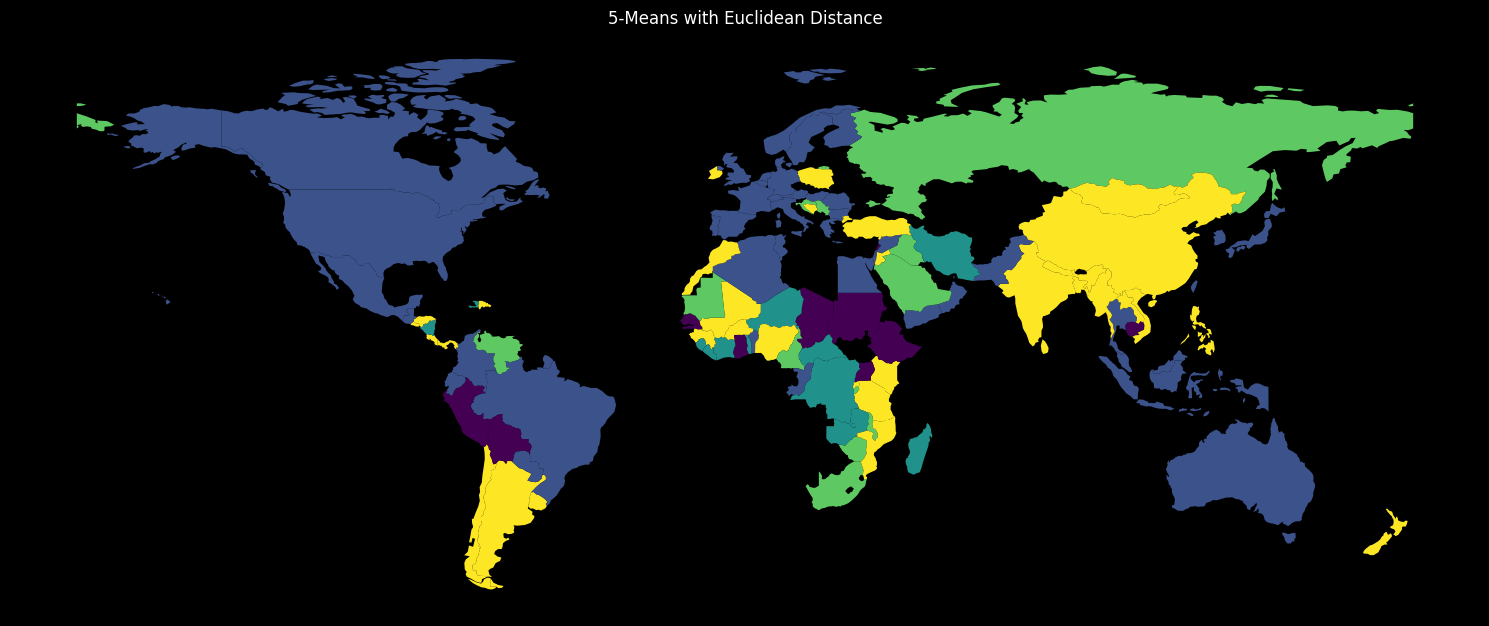

In [18]:
VisualUtils.show_clusters_on_map(names, y_km_e, map, '5-Means with Euclidean Distance')

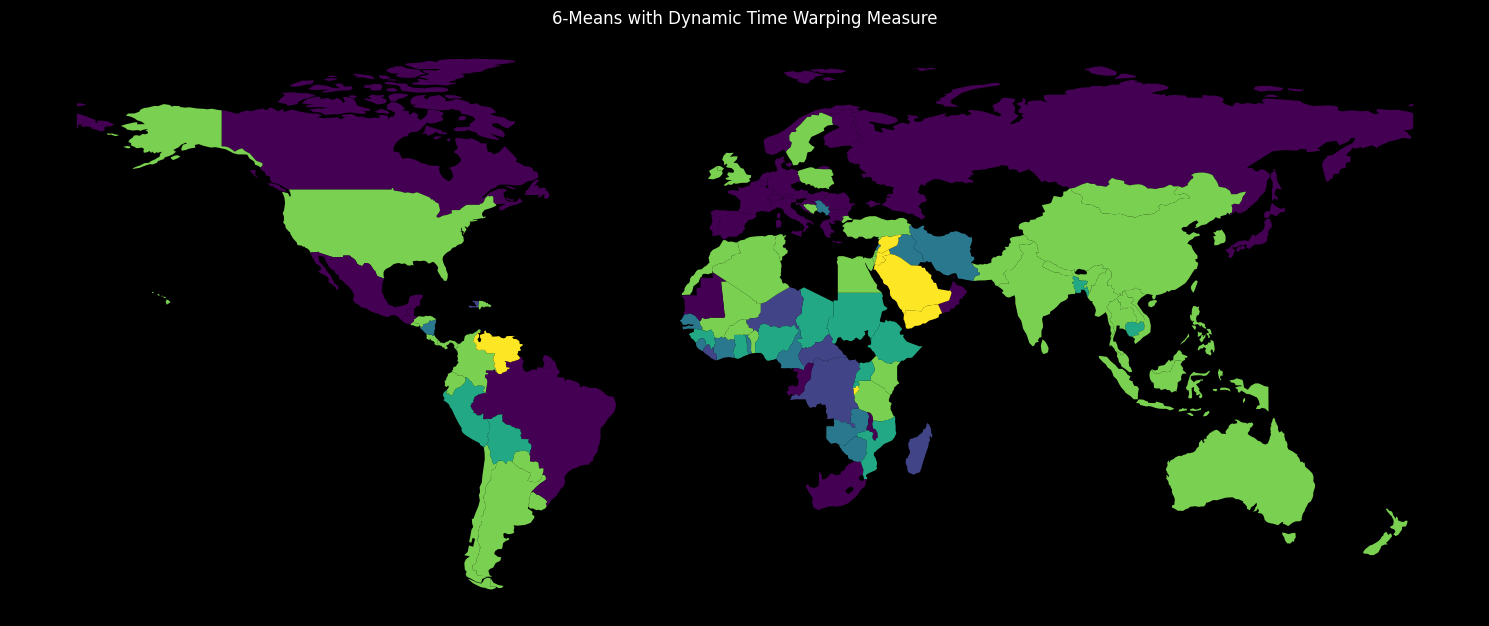

In [19]:
VisualUtils.show_clusters_on_map(names, y_km, map, '6-Means with Dynamic Time Warping Measure')

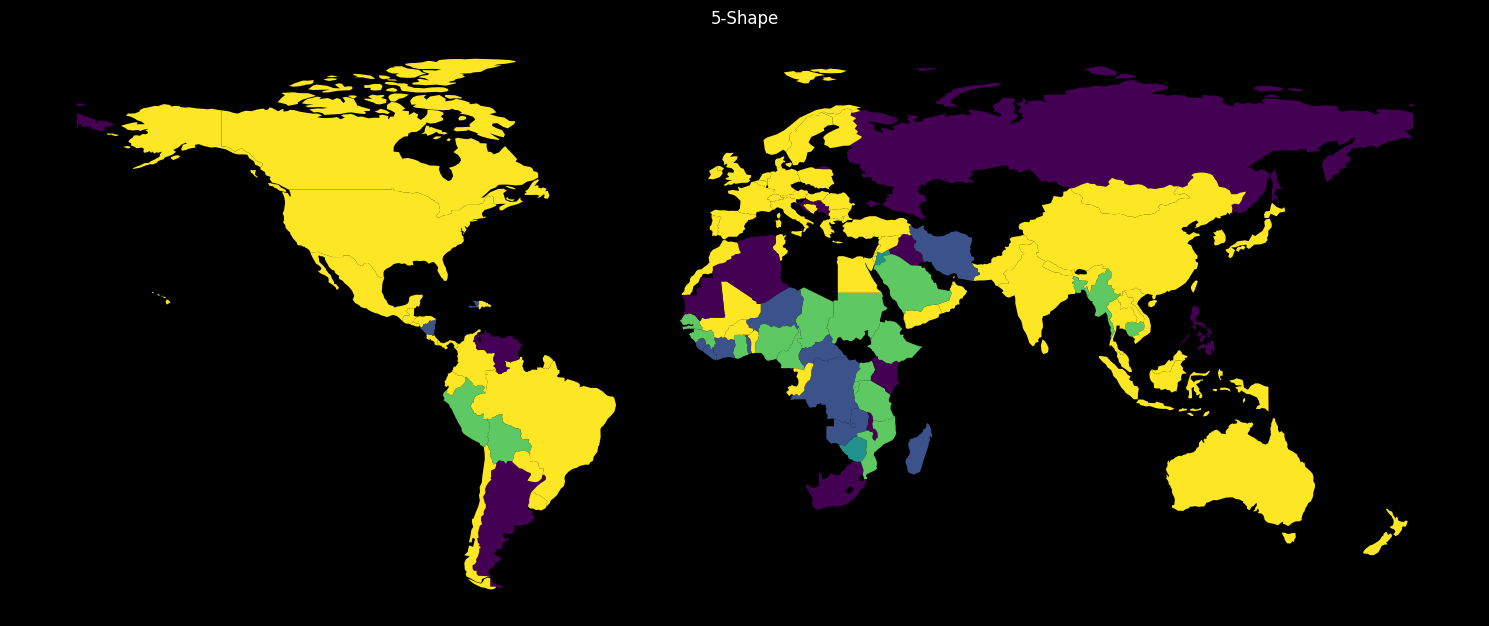

In [20]:
VisualUtils.show_clusters_on_map(names, y_s, map, '5-Shape')

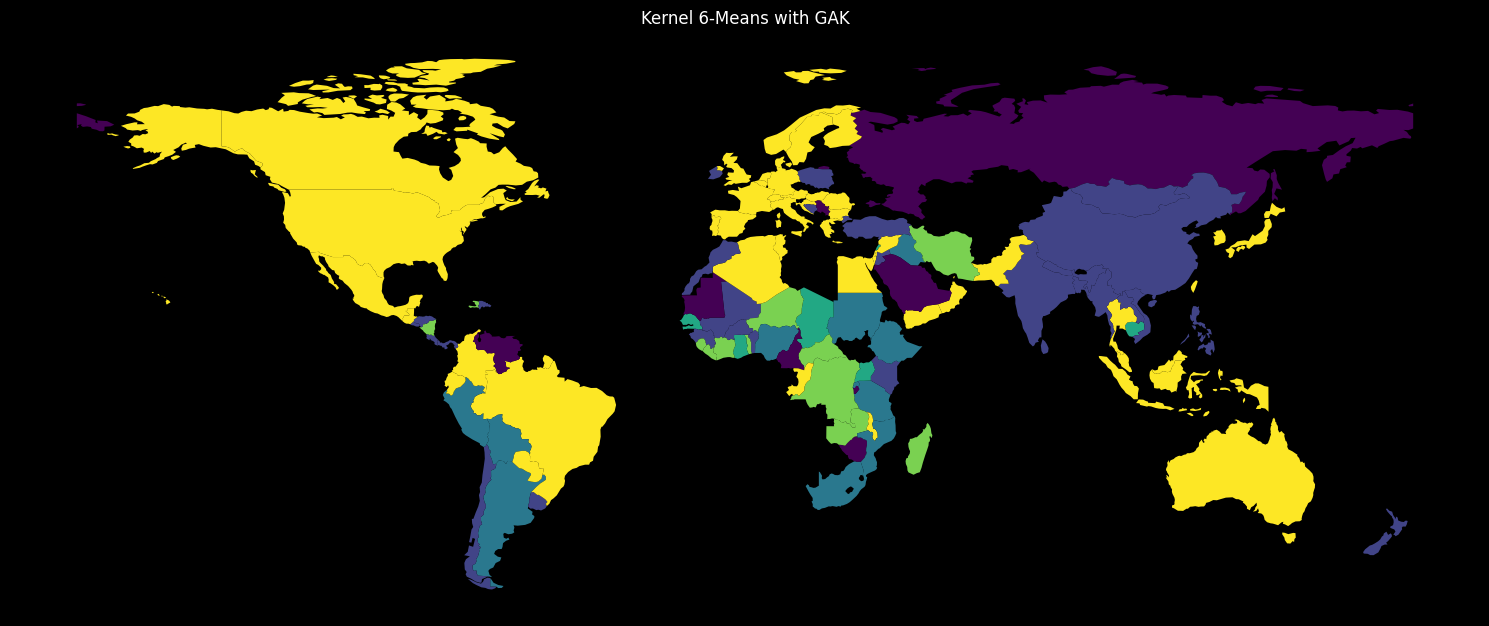

In [21]:
VisualUtils.show_clusters_on_map(names, y_k, map, 'Kernel 6-Means with GAK')

### Post Processing

It appears that kernel $6$-Means is the algorithm that produces the best structured clusters. We display how this partition relates to several types of commonly accepted groups of countries

In [22]:
groups_path = "Data/groups.txt"
groups = DataUtils.load_groups(groups_path)

In [23]:
from Utils import PostProcessing

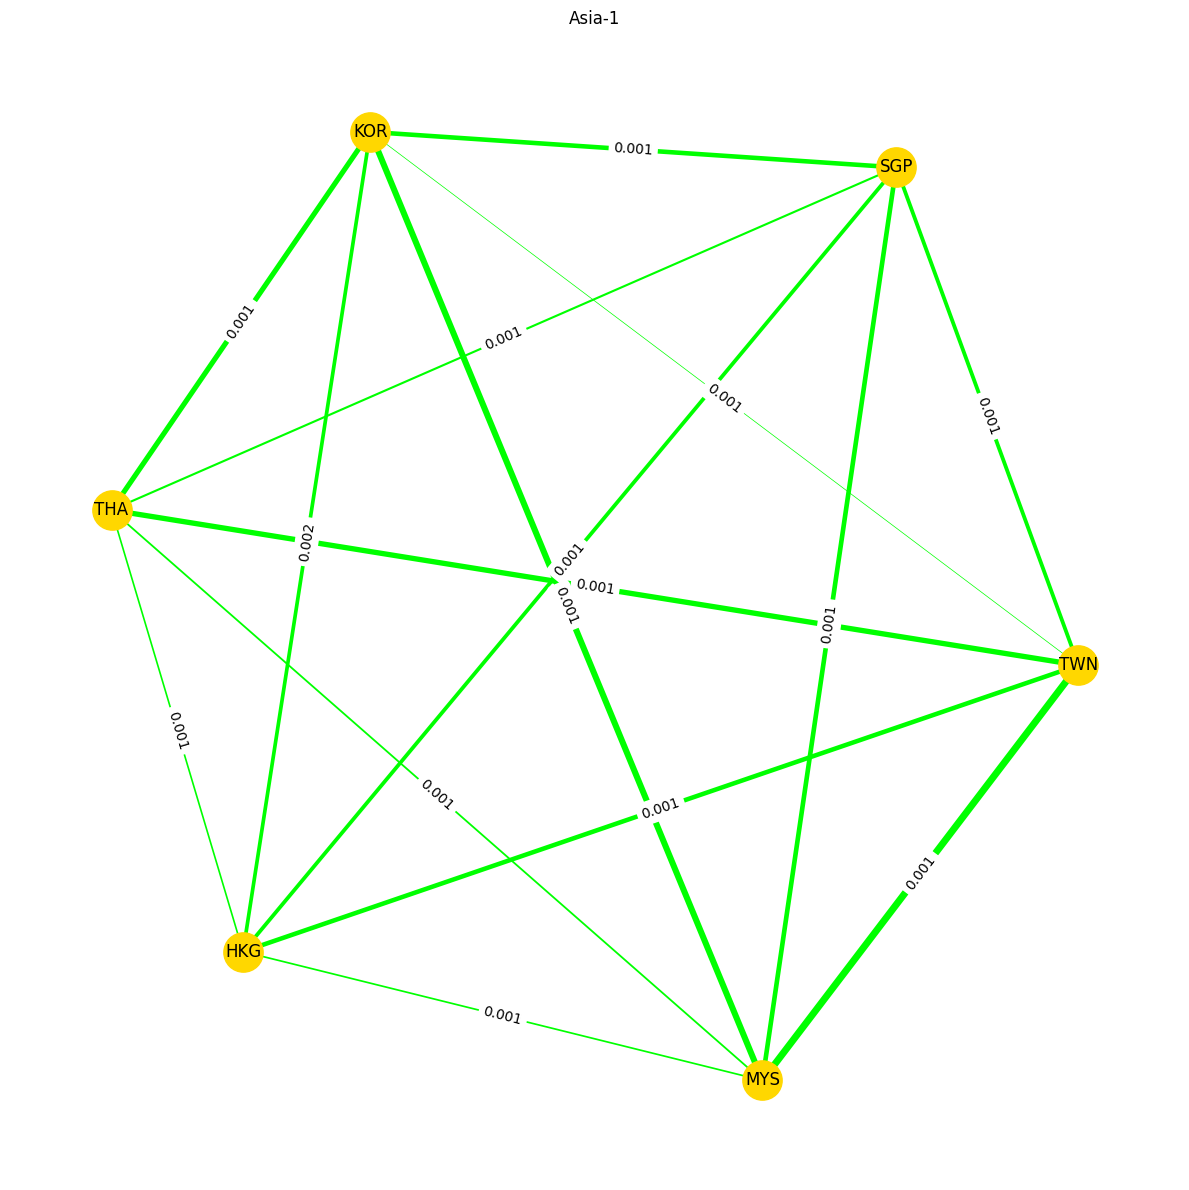

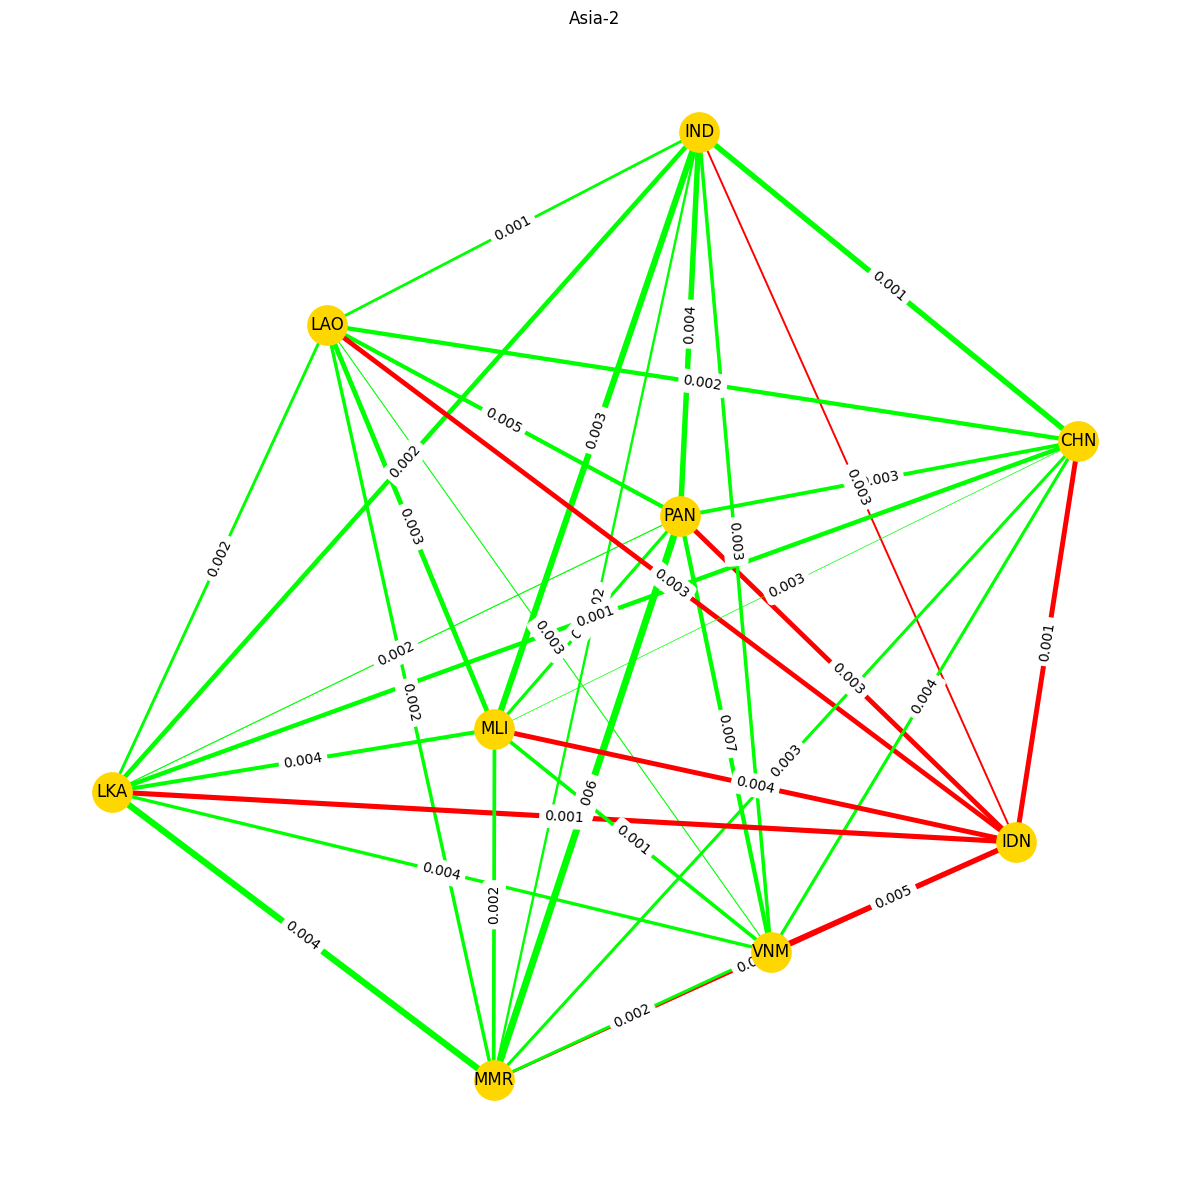

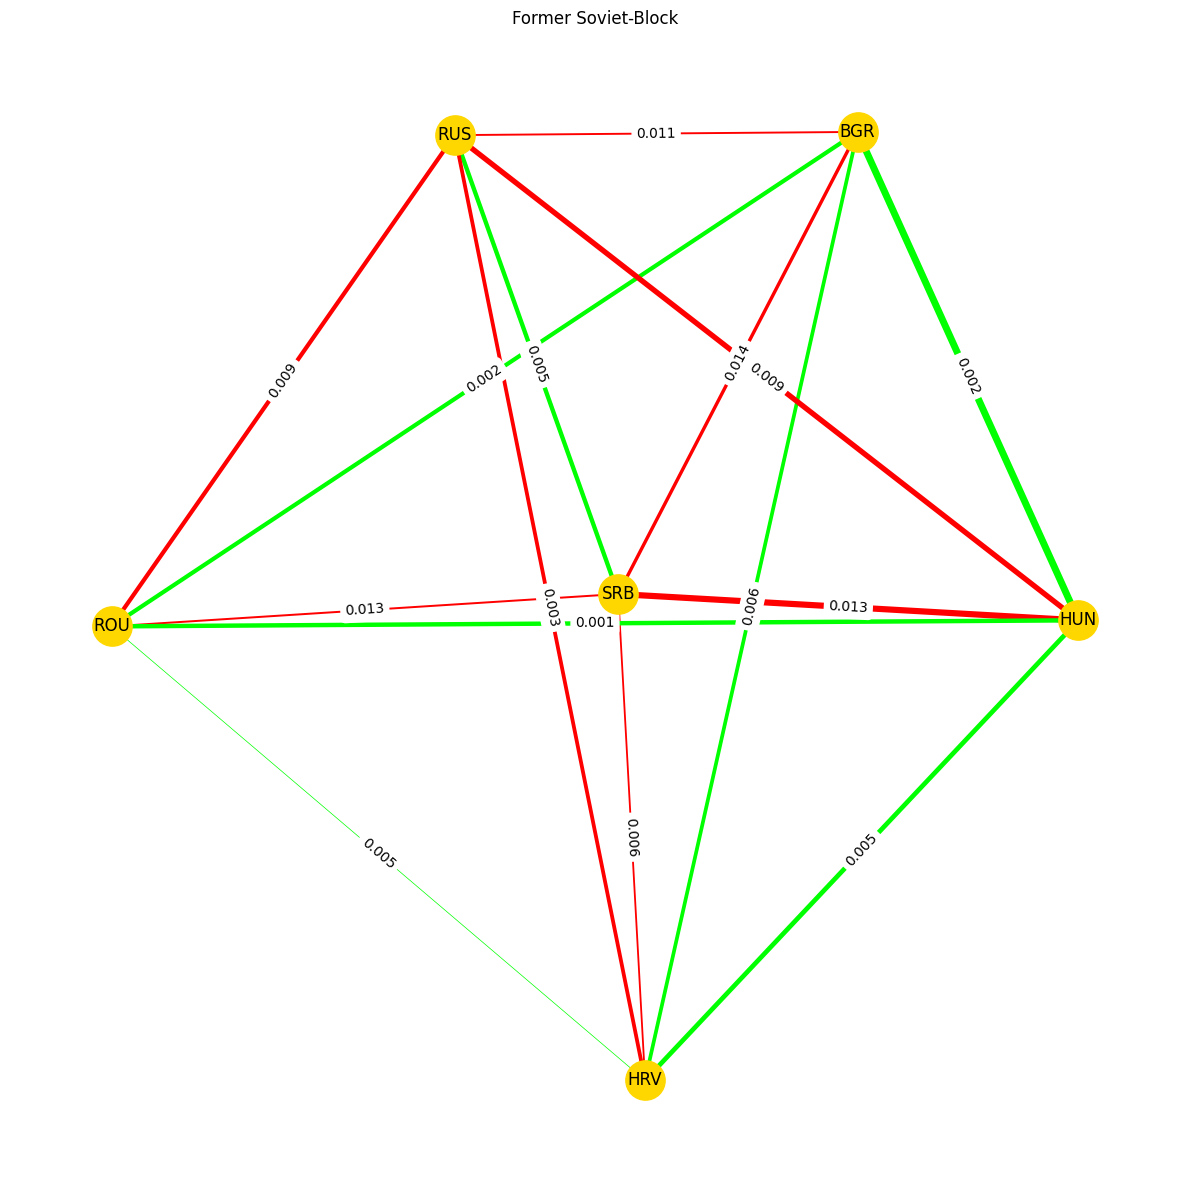

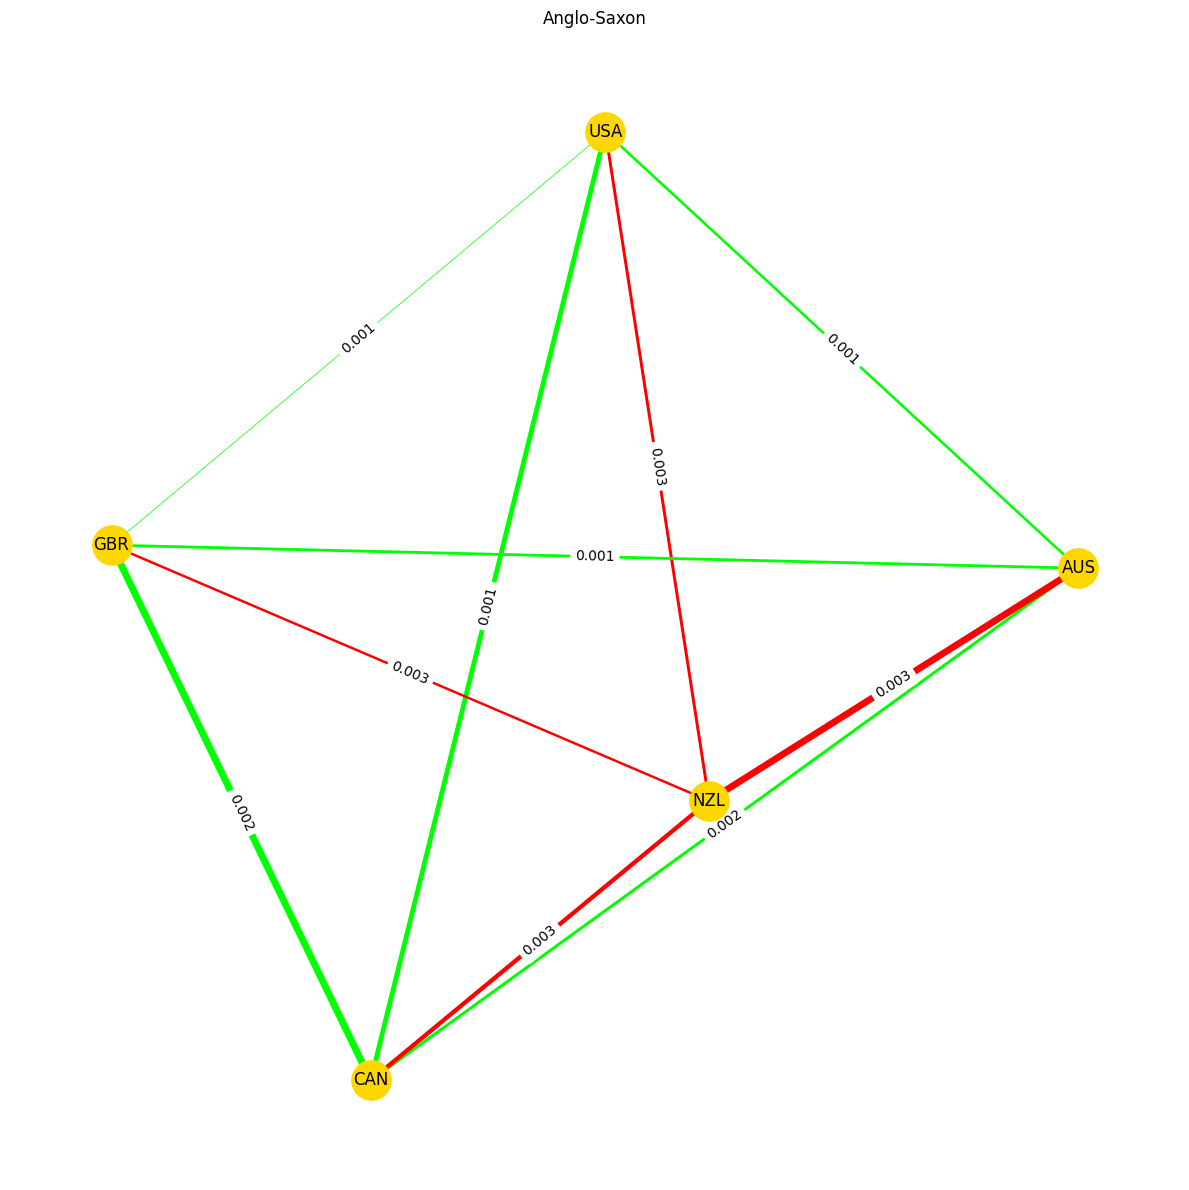

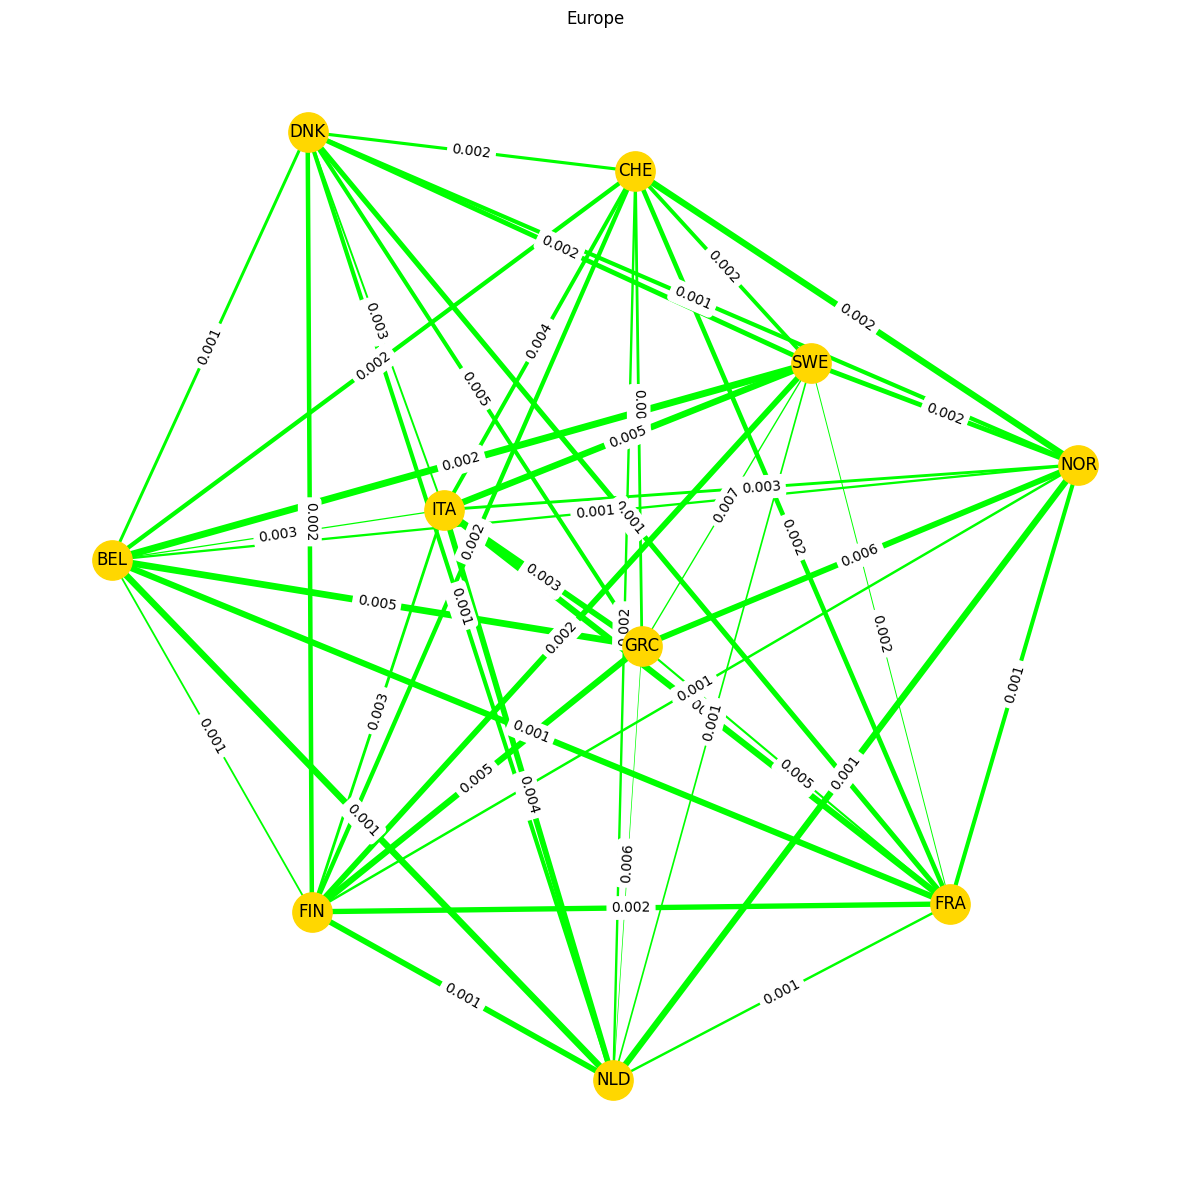

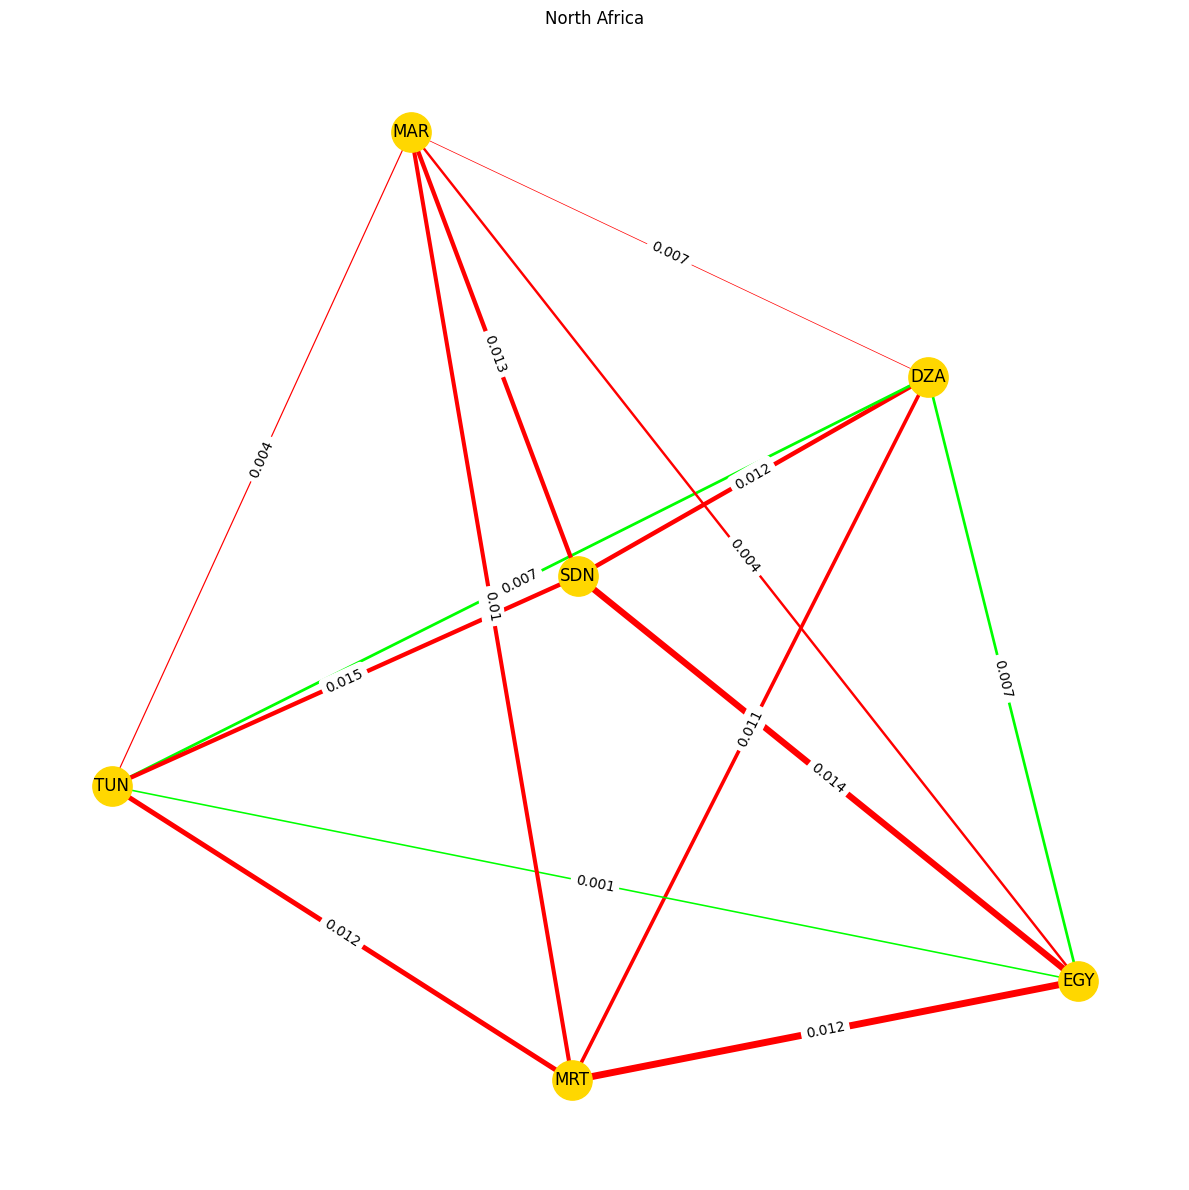

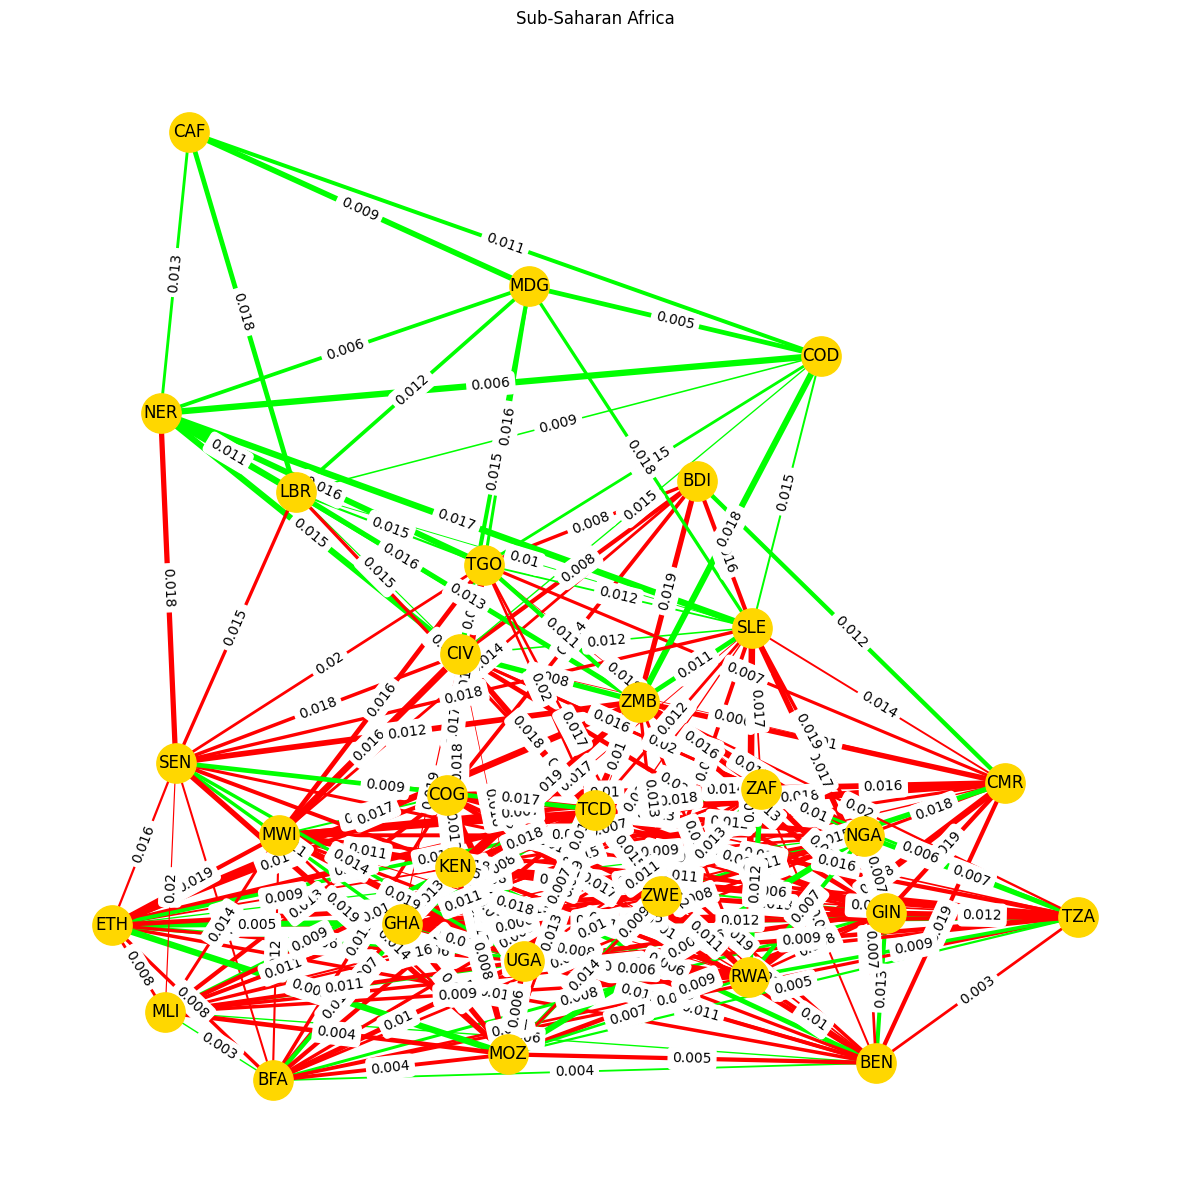

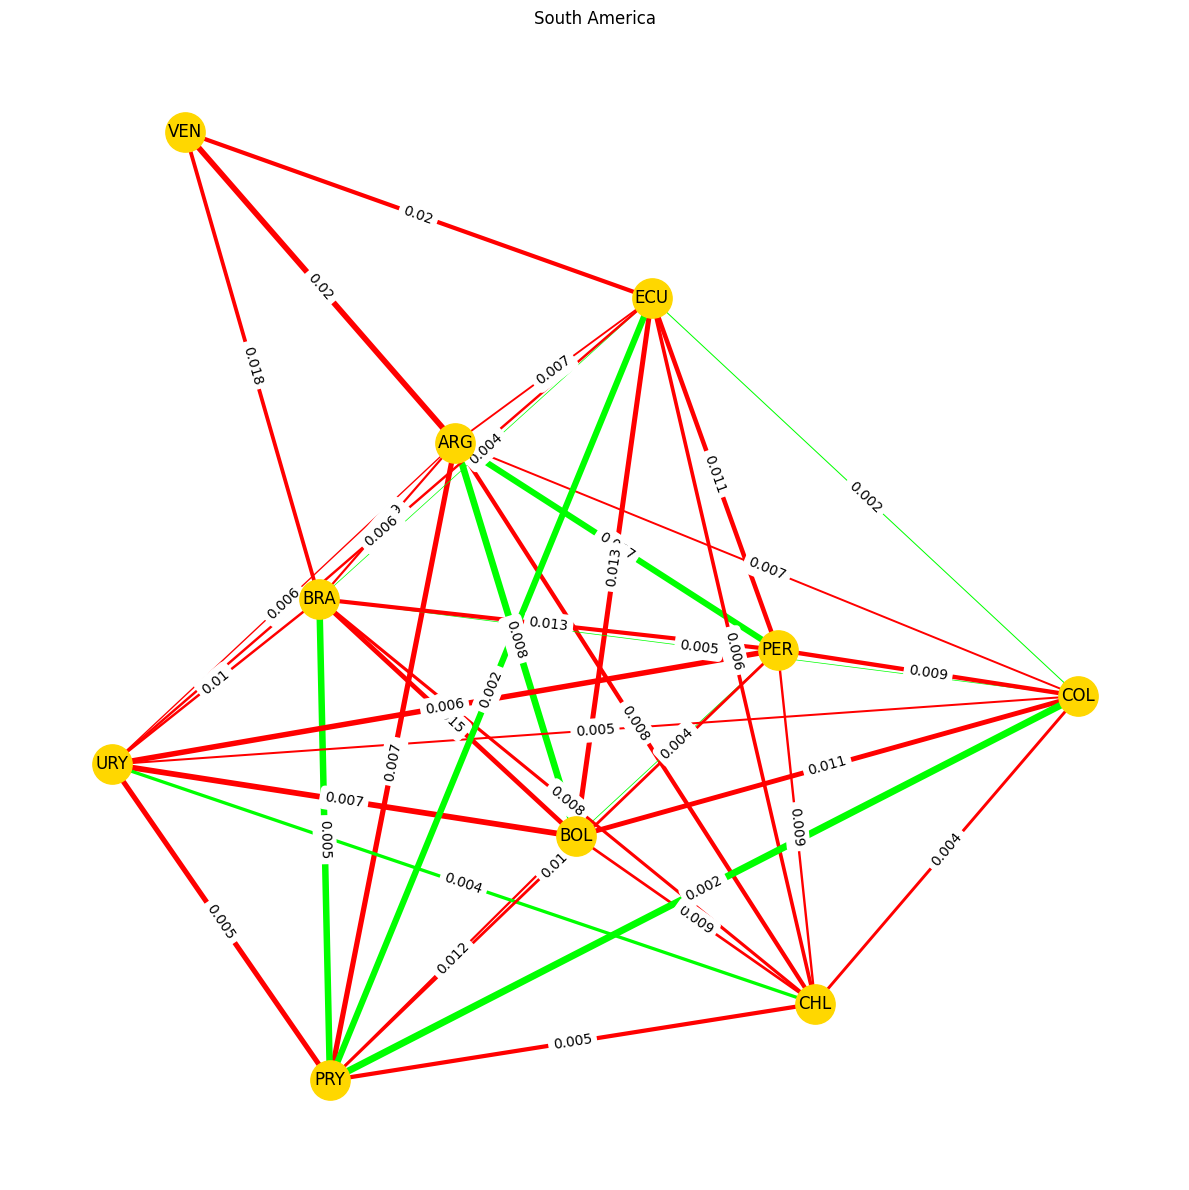

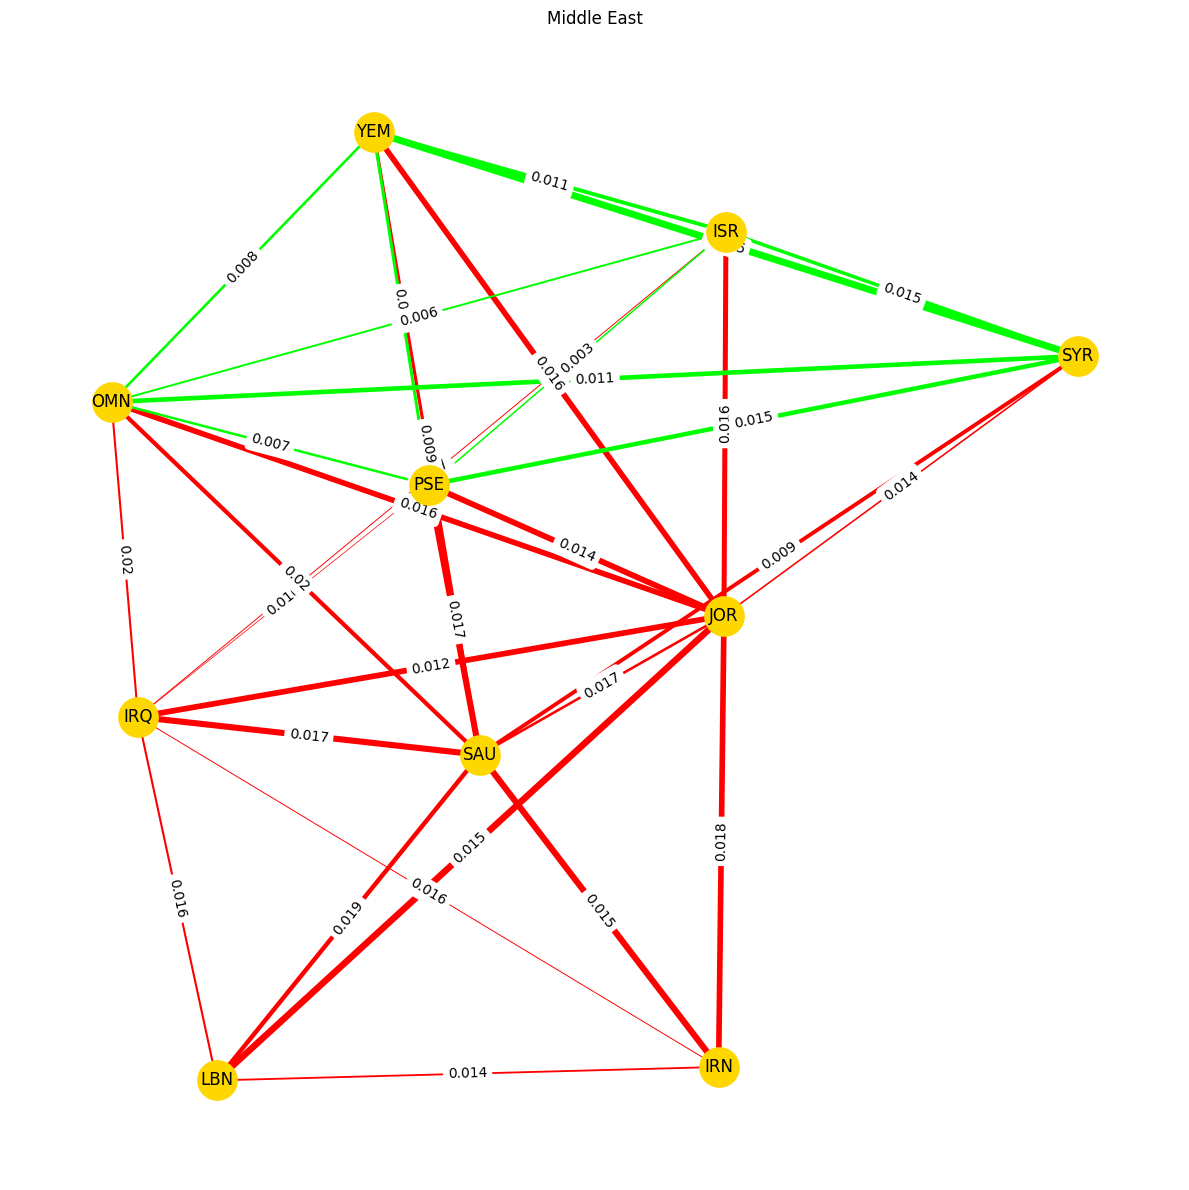

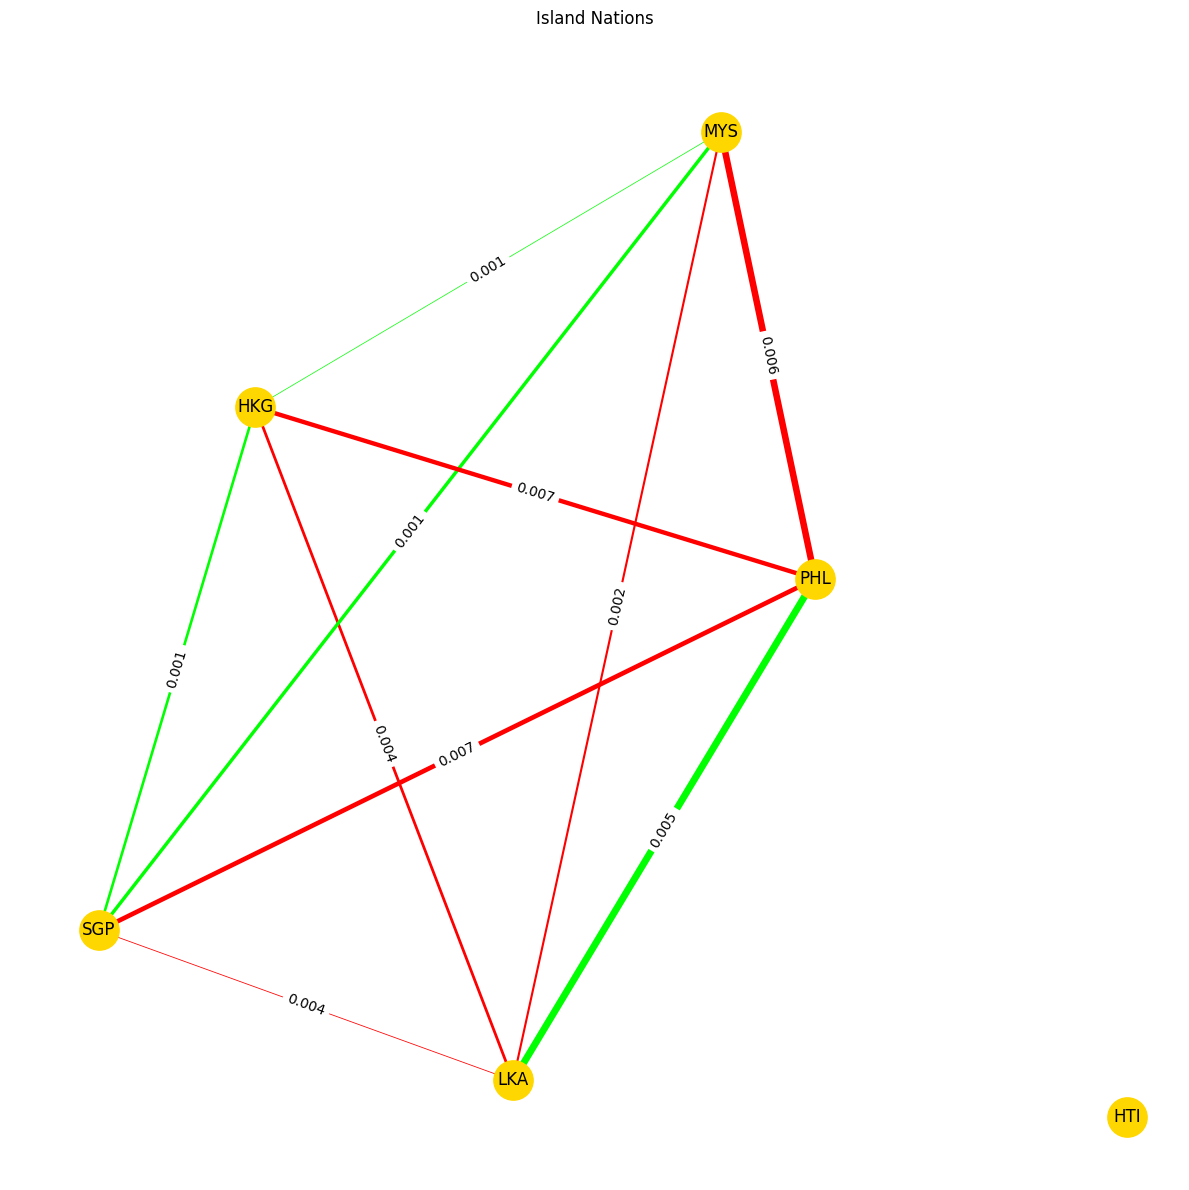

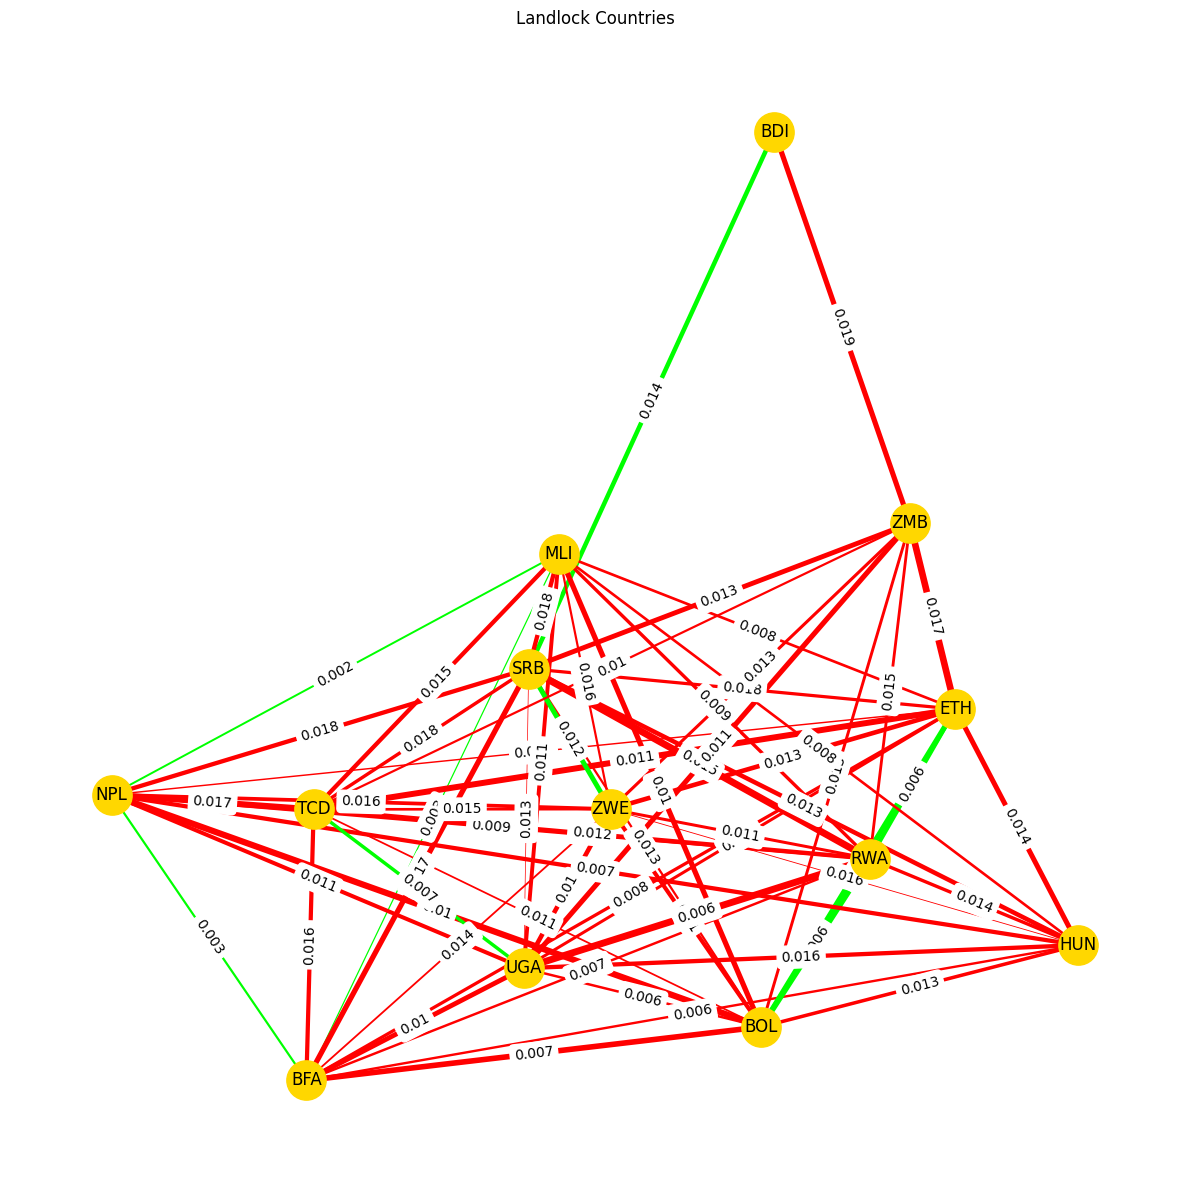

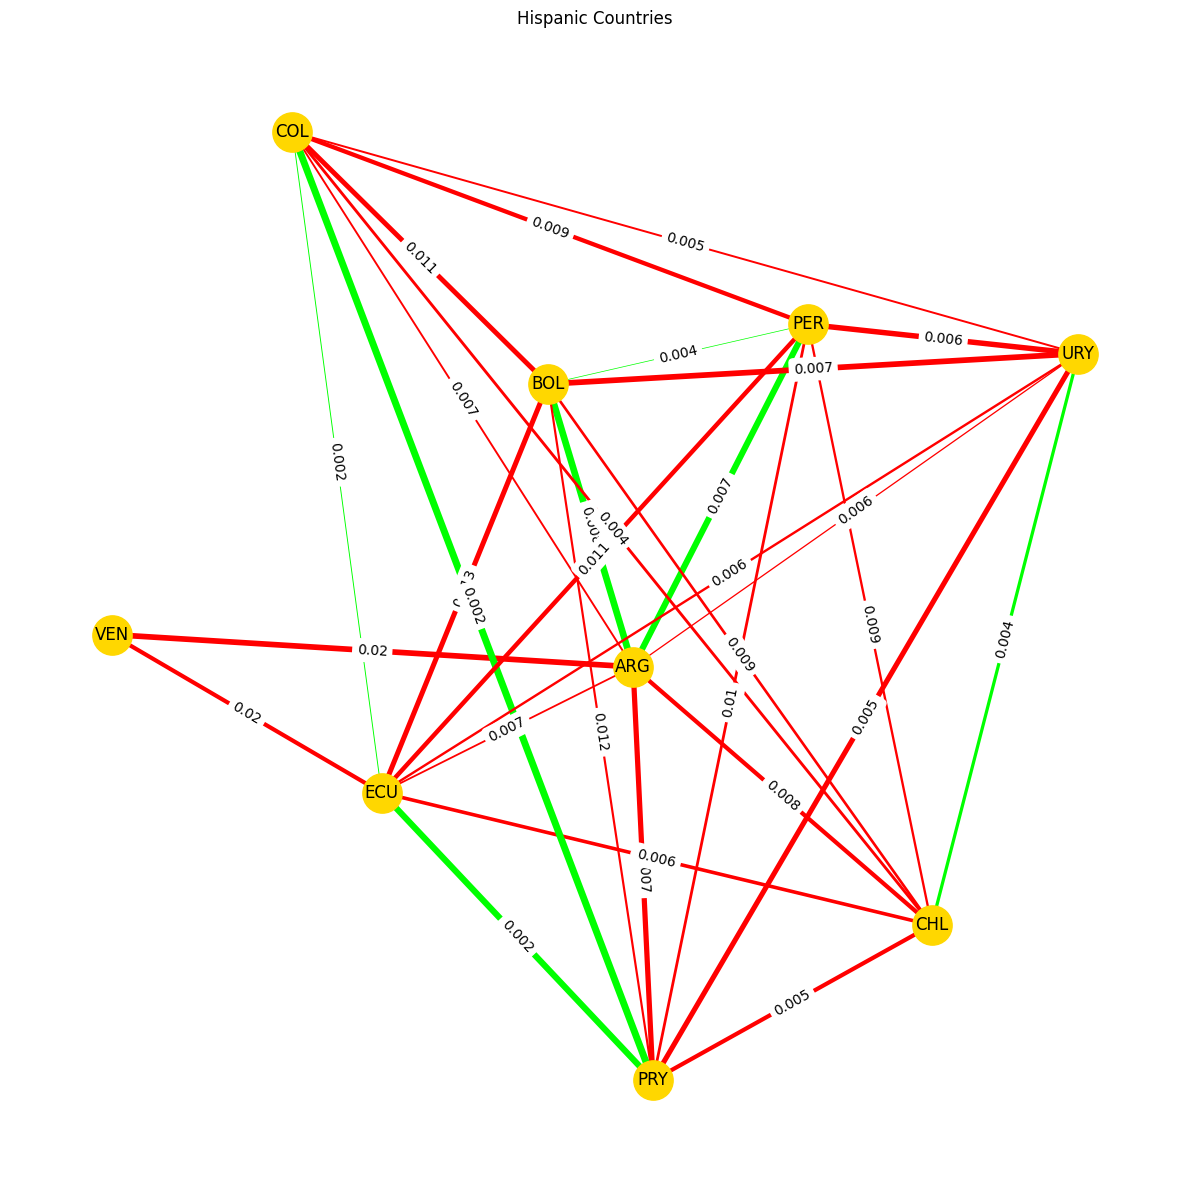

In [24]:
PostProcessing.postprocess_clustering(scaled_data, locations, names, groups, y_k)

## Conclusion
The best suited algorithm for this task is kernel $k$-means with $k=6$ clusters.
 
Overall, it looks like the partitioning algorithms specifically designed for time series clustering outperform the hierarchical and spectral clustering apporaches taken in this project. The fact that the cluster centroids are calculated as time series for all algorithms apart from kernel $k$-Means is very useful when considering the end goal of the project, which is to tune one regressive neural network model for each cluster. This study also produces the ideas of explicitly calculating the cluster barycenters using DBA for other approached that do not use centroids in the feature space (i.e. hierarchical clustering) and of using DTW in the context of spectral clustering.